In [1]:
import sys
sys.path.append('/Users/gk/repos/pp2/Non-stationary-point-process')
from pointprocess.simulation.hawkes_exp import HawkesExp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from hmmlearn.hmm import GaussianHMM

In [2]:
# Correct import - use the actual function that exists
from pointprocess.estimation.mle import fit_hawkes

In [3]:
df1 = pd.read_csv(
    "/Users/gk/Downloads/SG/SG_20170117.csv.gz",
    compression='gzip',
    parse_dates=["ets"],
    index_col=0,
    date_format='%Y%m%d:%H:%M:%S.%f',
    engine='pyarrow'
)

In [4]:
start_time = df1.ets.min()
event_times = (df1.ets - start_time).dt.total_seconds().values
T = event_times.max()
#event_times = event_times/T

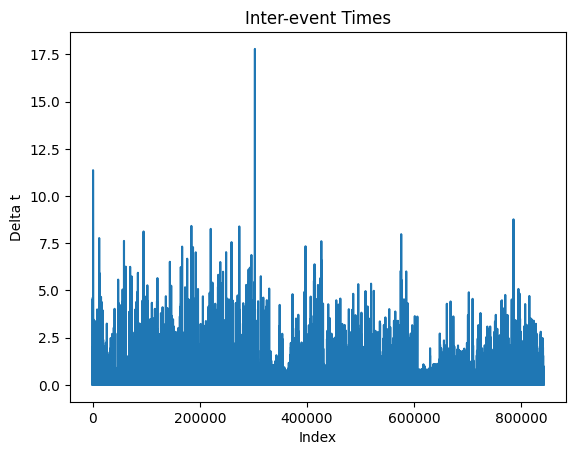

In [5]:
ax = sns.lineplot(x=range(len(event_times)-1), y=np.diff(event_times))
ax.set_xlabel('Index')
ax.set_ylabel('Delta t')
ax.set_title('Inter-event Times')
plt.show()

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

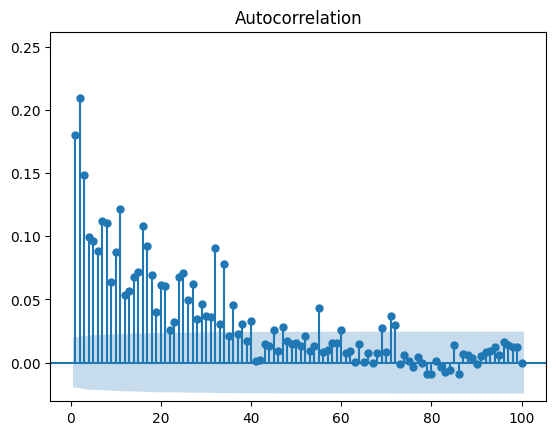

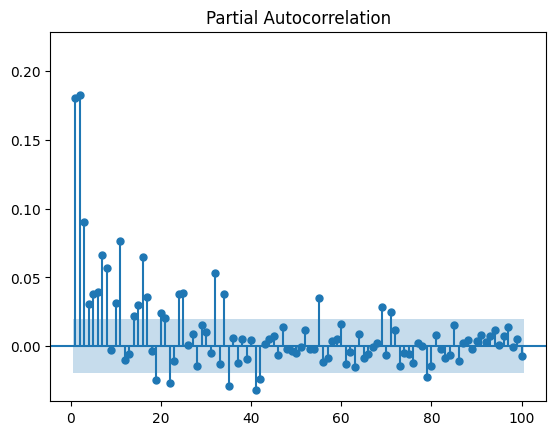

In [7]:
plot_acf(np.diff(event_times[:10000]), lags=100,zero=False, auto_ylims=True)
plot_pacf(np.diff(event_times[:10000]), lags=100,zero=False, auto_ylims=True, method="ols")
plt.show()

In [8]:
len(event_times)

841149

In [13]:
from hmmlearn.hmm import GaussianHMM
N_t = np.array(range(len(event_times)))
model = GaussianHMM(
    n_components=2,
    covariance_type="full",
    n_iter=200,
    random_state=0
).fit(np.array([event_times,N_t]).T)

hidden_states = model.predict(np.array([event_times,N_t]).T)

In [16]:
# Use HMM to scan event_times and detect regime-change boundaries (stationary intervals)
stationary_intervals = []
n_events = len(event_times)
begin_idx = 0
step = 10 
step_events = max(1, step)  # use existing `step`, ensure >=1
min_samples = 30  # minimum samples to accept an interval
while begin_idx < n_events:
    # start with minimum window
    end_idx = begin_idx + min_samples
    if end_idx > n_events:
        break

    found_change = False
    # expand window until a change in predicted HMM state appears or we reach the end
    while end_idx <= n_events:
        feats = np.column_stack((event_times[begin_idx:end_idx], np.arange(begin_idx, end_idx)))
        try:
            states = model.predict(feats)
        except Exception as e:
            print("HMM predict failed:", e)
            break

        # require at least min_samples states to judge
        if len(states) < min_samples:
            end_idx += step_events
            continue

        # if all states in window are identical -> still stationary, expand
        if np.all(states == states[0]):
            end_idx += step_events
            continue

        # regime change detected within this window
        found_change = True
        # first index (relative) where state differs from initial state
        change_rel = np.where(states != states[0])[0][0]
        record_end_idx = begin_idx + change_rel  # end index (exclusive) of homogeneous block

        # record interval if long enough
        if record_end_idx - begin_idx >= min_samples:
            t0 = event_times[begin_idx]
            t1 = event_times[record_end_idx - 1]
            stationary_intervals.append((t0, t1))
            print(f"Stationary interval: {t0:.3f} - {t1:.3f} sec (duration: {(t1 - t0):.3f} sec)")

        # continue scanning from the change point
        begin_idx = record_end_idx
        break

    # if we reached the end without detecting a change, record remaining block if long enough
    if not found_change:
        if n_events - begin_idx >= min_samples:
            t0 = event_times[begin_idx]
            t1 = event_times[-1]
            stationary_intervals.append((t0, t1))
            print(f"Stationary interval (end): {t0:.3f} - {t1:.3f} sec (duration: {(t1 - t0):.3f} sec)")
        break

    # safety guard
    if len(stationary_intervals) > 10000:
        print("Stopping: too many intervals")
        break

print(f"\nTotal stationary intervals found: {len(stationary_intervals)}")

Stationary interval: 0.000 - 11650.440 sec (duration: 11650.440 sec)

Total stationary intervals found: 1


In [ ]:
from statsmodels.tools.sm_exceptions import InterpolationWarning
import warnings

warnings.filterwarnings("ignore", category=InterpolationWarning)

begin = 0
end = 100  # Start with larger window
step = 10  # Bigger step for efficiency
min_samples = 30  # Minimum samples for reliable ADF test
adf_result = True
stationary_intervals = []

while begin < T:
    end = begin + 100  # Reset end for each new search
    adf_result = True
    
    while adf_result and end < T:
        end += step
        
        timeseries = event_times[(event_times >= begin) & (event_times <= end)]
        
        # Check minimum sample size
        if len(timeseries) < min_samples:
            continue
        
        try:
            adf_full_result = adfuller(timeseries, autolag="AIC")
            adf_pvalue = adf_full_result[1]
            adf_result = adf_pvalue < 0.1  # Use 0.05 for stricter test
        except:
            break  # Exit if ADF fails
    
    # Record the stationary interval (go back one step)
    if end > begin + 100:  # Only record if we found something
        stationary_intervals.append((begin, end - step))
        print(f"Stationary interval: {begin:.1f} - {end-step:.1f} sec (duration: {end-step-begin:.1f} sec)")
    
    # Move to next non-overlapping interval
    begin = end - step
    
    # Safety: stop if too many intervals
    if len(stationary_intervals) > 1000:
        print("Stopping: too many intervals")
        break

print(f"\nTotal stationary intervals: {len(stationary_intervals)}")

In [ ]:
# Fit Hawkes Exponential Model
print("Fitting Hawkes Exponential Model...")
result_exp = fit_hawkes(event_times, T, H0="exp")

print(f"Optimization success: {result_exp.success}")
print(f"Log-likelihood: {-result_exp.fun:.2f}")
print("Parameters:")
for param, value in result_exp.params_dict.items():
    print(f"  {param}: {value:.6f}")

Fitting Hawkes Exponential Model...
Optimization success: True
Log-likelihood: 4511058.73
Parameters:
  mu: 6.730148
  alpha: 1970.143593
  beta: 2176.678707


In [ ]:
# Fit Hawkes Power Law Model
print("\nFitting Hawkes Power Law Model...")
#result_pl = fit_hawkes(event_times, T, H0="pl")

print(f"Optimization success: {result_pl.success}")
print(f"Log-likelihood: {-result_pl.fun:.2f}")
print("Parameters:")
for param, value in result_pl.params_dict.items():
    print(f"  {param}: {value:.6f}")


Fitting Hawkes Power Law Model...


NameError: name 'result_pl' is not defined

In [ ]:
# Fit Hawkes Multi-Exponential Model
print("\nFitting Hawkes Multi-Exponential Model...")
result_multiexp = fit_hawkes(event_times, T, H0="multiexp")

print(f"Optimization success: {result_multiexp.success}")
print(f"Log-likelihood: {-result_multiexp.fun:.2f}")
print("Parameters:")
for param, value in result_multiexp.params_dict.items():
    if isinstance(value, np.ndarray):
        print(f"  {param}: {value}")
    else:
        print(f"  {param}: {value:.6f}")



Fitting Hawkes Multi-Exponential Model...
Optimization success: True
Log-likelihood: 4552890.74
Parameters:
  mu: 6.883115
  alphas: [  34.0443296    84.82353242 1695.38479769]
  betas: [1053.88953809  795.8781629  2439.60036634]
  J: 3.000000


In [56]:
len(event_times)//1000

841

In [61]:
# Compute intensity properly first
num_points = 1000
time_bins = np.linspace(0, T, num_points)
Nt = np.searchsorted(event_times, time_bins, "left")
# Intensity = change in count / change in time
intensity_vals = np.diff(Nt) / np.diff(time_bins)
time_mids = (time_bins[:-1] + time_bins[1:]) / 2  # midpoints

# Now compute weighted moving average on the INTENSITY
wma = [[], []]
window_size = num_points//10  # Use fixed window size (not dependent on event_times length)

i = 0
while i <= len(intensity_vals) - window_size:
    mid_time = time_mids[i + window_size // 2]
    segment = intensity_vals[i:i + window_size]
    # Weights: more recent = higher weight
    weights = np.arange(1, len(segment) + 1)  # Linear increasing weights
    wma[0].append(mid_time)
    wma[1].append(np.average(segment, weights=weights))
    i += window_size // 2  # 50% overlap for smoother curve

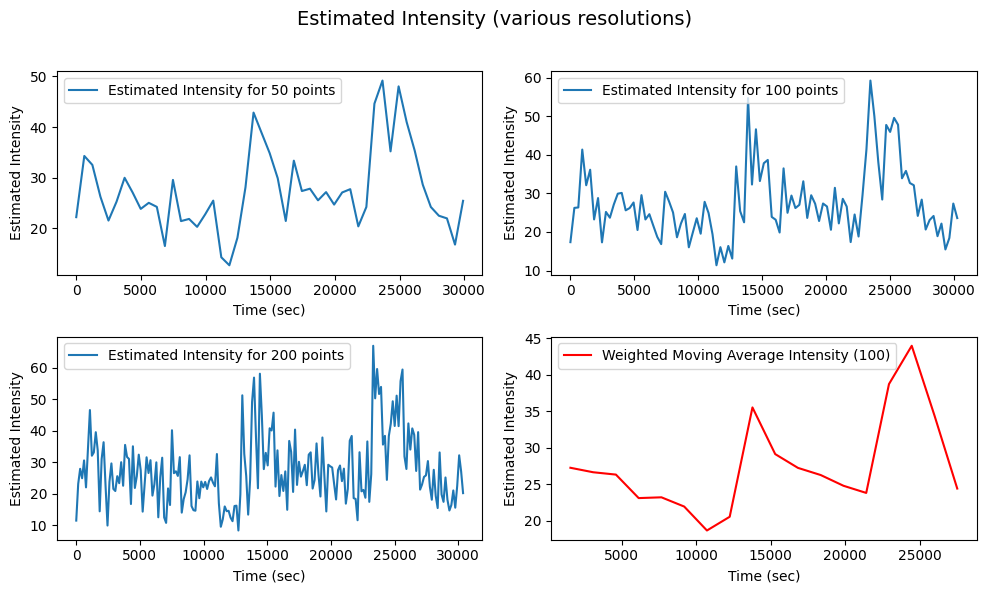

In [64]:
def intensity(num_points):
    time_array = np.linspace(0, T, num_points)
    Nt = np.searchsorted(event_times, time_array, "left")
    intensity_ = np.diff(Nt) / np.diff(time_array)
    return time_array[:-1], intensity_

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes_flat = axes.flatten()

# plot estimated intensities for different resolutions in the first three subplots
for ax, num_points in zip(axes_flat[:3], [50, 100, 200]):
    t, lambd = intensity(num_points)
    sns.lineplot(x=t, y=lambd, ax=ax, label=f'Estimated Intensity for {num_points} points')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Estimated Intensity')
    ax.legend()

# plot the average intensity in the last subplot
last_ax = axes_flat[3]
Nt = np.searchsorted(event_times, np.linspace(0, T, 10000), "left")
sns.lineplot(x=wma[0], y=wma[1], ax=last_ax, label=f'Weighted Moving Average Intensity ({window_size})', color='red')
last_ax.set_xlabel('Time (sec)')
last_ax.set_ylabel('Estimated Intensity')
last_ax.legend()

fig.suptitle('Estimated Intensity (various resolutions)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Simulating Exponential model...
  Simulation 1: 2195852 total events, 2195852 in window

Simulating Multi-Exponential model...
  Simulation 1: 1264626 total events, 1264626 in window


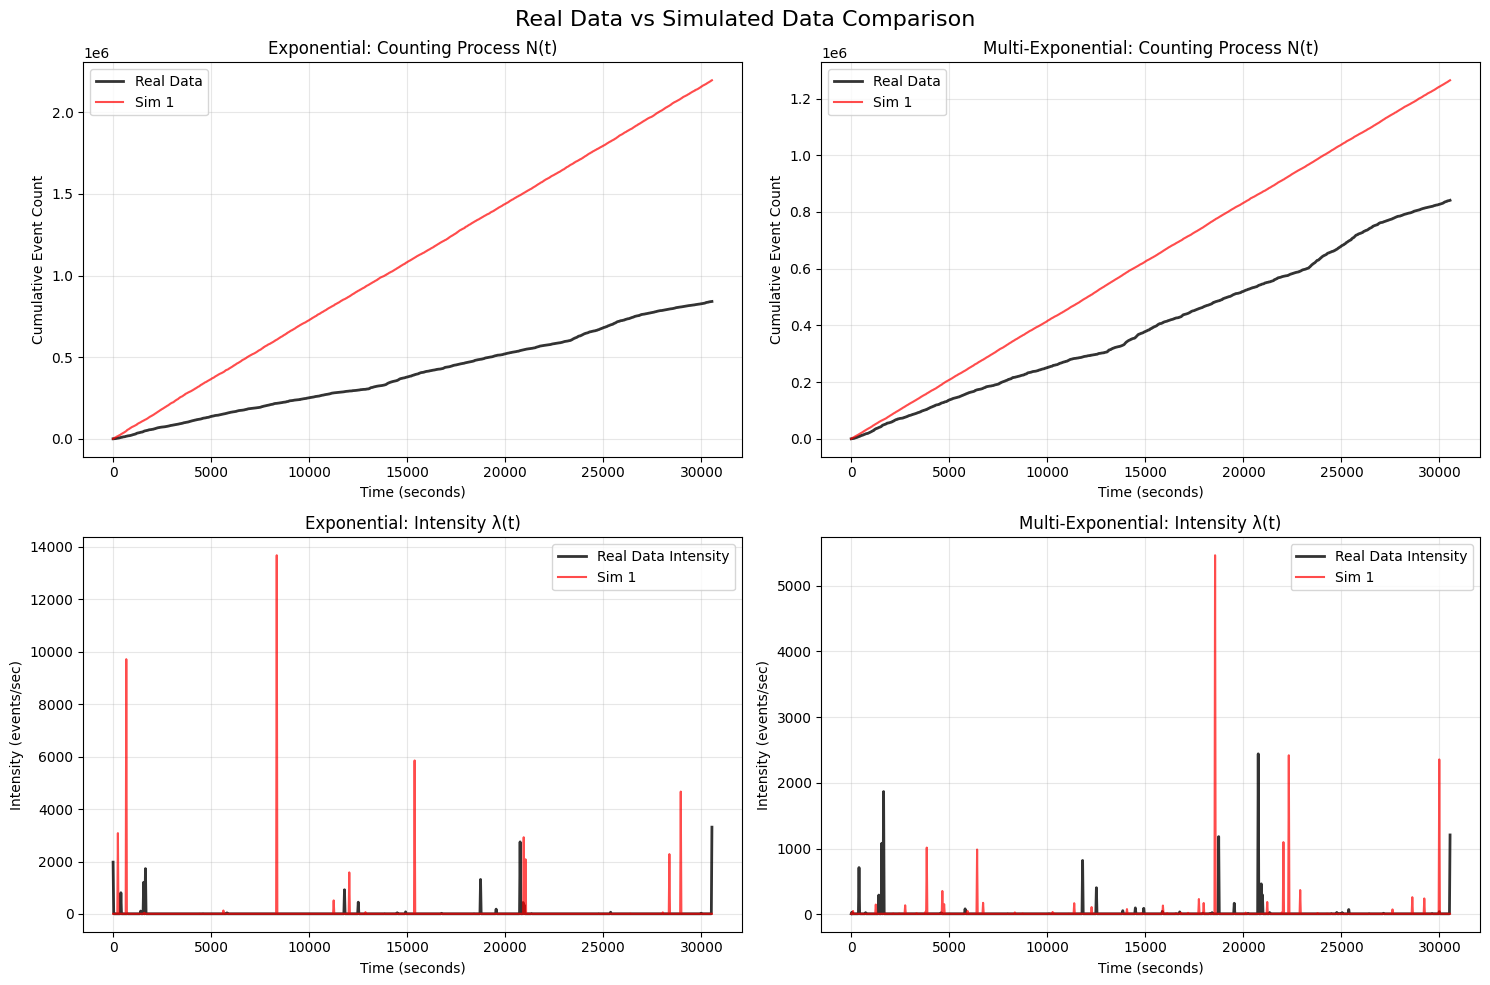


SUMMARY STATISTICS
Real Data:
  Total events: 841149
  Event rate: 27.542779 events/sec

Exponential Model:
  Parameters: μ=6.730148, α=1970.143593, β=2176.678707
  Log-likelihood: 4511058.73

Multi-Exponential Model:
  Parameters: μ=6.883115
  Alphas: [  34.0443296    84.82353242 1695.38479769]
  Betas: [1053.88953809  795.8781629  2439.60036634]
  Log-likelihood: 4552890.74


In [ ]:
# Simplified simulation and comparison
from pointprocess.simulation.hawkes_exp import HawkesExp
from pointprocess.simulation.hawkes_multiexp import HawkesMultiExp

def simple_simulate_and_compare(real_events, T, fitted_results, n_simulations=3):
    """
    Simple comparison with N(t) and intensity plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Real Data vs Simulated Data Comparison', fontsize=16)
    
    models = {
        'Exponential': fitted_results['exp'],
        'Multi-Exponential': fitted_results['multiexp']
    }
    
    colors = ['red', 'blue', 'green']
    
    # Time grid for plotting (first 2 hours for better visibility)
    max_time = T#min(T, 7200)  # 2 hours
    time_grid = np.linspace(0, max_time, 1000)
    
    for col, (model_name, result) in enumerate(models.items()):
        print(f"\nSimulating {model_name} model...")
        
        # Extract parameters
        if model_name == 'Exponential':
            params = {
                "T": T,
                "mu": result.params_dict['mu'],
                "alpha": result.params_dict['alpha'],
                "beta": result.params_dict['beta']
            }
        else:  # Multi-Exponential
            params = {
                "T": T,
                "mu": result.params_dict['mu'],
                "alphas": result.params_dict['alphas'],
                "betas": result.params_dict['betas']
            }
        
        # Generate simulations
        simulated_events = []
        for i in range(n_simulations):
            if model_name == 'Exponential':
                hawkes = HawkesExp(params)
            else:
                hawkes = HawkesMultiExp(params)
            
            sim_events = np.array(hawkes.events)
            sim_events = sim_events[sim_events <= max_time]  # Keep only events in time window
            simulated_events.append(sim_events)
            print(f"  Simulation {i+1}: {len(hawkes.events)} total events, {len(sim_events)} in window")
        
        # Plot 1: N(t) - Cumulative count function
        ax1 = axes[0, col]
        
        # Real data N(t)
        real_subset = real_events[real_events <= max_time]
        #real_N_t = np.searchsorted(real_subset, time_grid, side='right')
        real_N_t = np.array(range(len(event_times)))  # Ensure it's a numpy array
        ax1.plot(event_times, real_N_t, 'k-', linewidth=2, label='Real Data', alpha=0.8)
        
        # Simulated N(t)
        for i, sim_events in enumerate(simulated_events):
            #sim_N_t = np.searchsorted(sim_events, time_grid, side='right')
            sim_N_t = np.array(range(len(sim_events)))  # Ensure it's a numpy array
            ax1.plot(sim_events, sim_N_t, color=colors[i], alpha=0.7, 
                    linewidth=1.5, label=f'Sim {i+1}')
        
        ax1.set_title(f'{model_name}: Counting Process N(t)')
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Cumulative Event Count')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Intensity λ(t)
        ax2 = axes[1, col]
        
        # Real data intensity
        if model_name == 'Exponential':
            real_intensity = HawkesExp._intensity_on_grid(time_grid, params, real_subset)
        else:
            real_intensity = HawkesMultiExp._intensity_on_grid(time_grid, params, real_subset)
        
        ax2.plot(time_grid, real_intensity, 'k-', linewidth=2, 
                label='Real Data Intensity', alpha=0.8)
        
        # Simulated intensities
        for i, sim_events in enumerate(simulated_events):
            if model_name == 'Exponential':
                sim_intensity = HawkesExp._intensity_on_grid(time_grid, params, sim_events)
            else:
                sim_intensity = HawkesMultiExp._intensity_on_grid(time_grid, params, sim_events)
            
            ax2.plot(time_grid, sim_intensity, color=colors[i], alpha=0.7,
                    linewidth=1.5, label=f'Sim {i+1}')
        
        ax2.set_title(f'{model_name}: Intensity λ(t)')
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Intensity (events/sec)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    real_count = len(real_events)
    real_rate = real_count / T
    
    print("Real Data:")
    print(f"  Total events: {real_count}")
    print(f"  Event rate: {real_rate:.6f} events/sec")
    
    for model_name, result in models.items():
        print(f"\n{model_name} Model:")
        if model_name == 'Exponential':
            params = result.params_dict
            print(f"  Parameters: μ={params['mu']:.6f}, α={params['alpha']:.6f}, β={params['beta']:.6f}")
        else:
            params = result.params_dict
            print(f"  Parameters: μ={params['mu']:.6f}")
            print(f"  Alphas: {params['alphas']}")
            print(f"  Betas: {params['betas']}")
        
        print(f"  Log-likelihood: {-result.fun:.2f}")
    
    return simulated_events

# Run the simplified comparison
fitted_results = {
    'exp': result_exp,
    'multiexp': result_multiexp
}

simulated_data = simple_simulate_and_compare(event_times, T, fitted_results, n_simulations=1)

In [ ]:
# Import the testing function
from pointprocess.testing.one_run import one_run

def simple_gof_test(real_events, T, fitted_results):
    """
    Simple goodness-of-fit test using the one_run function
    """
    print("Goodness-of-Fit Tests")
    print("=" * 50)
    
    models = [('exp', 'Exponential'), ('multiexp', 'Multi-Exponential')]
    
    for model_key, model_name in models:
        print(f"\n{model_name} Model:")
        print("-" * 30)
        
        try:
            # Test on real data
            ks_reject, ad_reject, cvm_reject = one_run(
                real_events, T, H0=model_key, method="khmaladze", alpha_level=0.05
            )
            
            print("Real Data Test Results:")
            print(f"  KS test:  {'REJECT H0' if ks_reject else 'ACCEPT H0'}")
            print(f"  AD test:  {'REJECT H0' if ad_reject else 'ACCEPT H0'}")
            print(f"  CvM test: {'REJECT H0' if cvm_reject else 'ACCEPT H0'}")
            
            # Interpretation
            rejected_tests = sum([ks_reject, ad_reject, cvm_reject])
            if rejected_tests == 0:
                print("  → Model fits the data well!")
            elif rejected_tests <= 1:
                print("  → Model fits reasonably well")
            else:
                print("  → Model does not fit the data well")
                
        except Exception as e:
            print(f"Error testing {model_name}: {e}")

# Run the simple test
simple_gof_test(event_times, T, fitted_results)

Goodness-of-Fit Tests

Exponential Model:
------------------------------
Real Data Test Results:
  KS test:  REJECT H0
  AD test:  REJECT H0
  CvM test: REJECT H0
  → Model does not fit the data well

Multi-Exponential Model:
------------------------------
Real Data Test Results:
  KS test:  REJECT H0
  AD test:  REJECT H0
  CvM test: REJECT H0
  → Model does not fit the data well

Multi-Exponential Model:
------------------------------
Real Data Test Results:
  KS test:  REJECT H0
  AD test:  REJECT H0
  CvM test: REJECT H0
  → Model does not fit the data well
Real Data Test Results:
  KS test:  REJECT H0
  AD test:  REJECT H0
  CvM test: REJECT H0
  → Model does not fit the data well
